<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

# Цель исследования
1. Построить модель, которая быстро и с наибольшим качеством прогрозирует количество заказов такси на следующий час.


# Ход исследования
Нам предоставленны данные данные из компании «Чётенькое такси» о заказах такси в аэропортах. Данные находятся в датафрейме, который мы получим из файла 'taxi.csv'. О качестве данных нам ничего не известно, поэтому перед тем, как приступать к целям исследования, понадобится обзор данных. Мы проверим данные на ошибки. Затем, на этапе предобработки мы будем искать возможность исправить все ошибки в данных, которые не приведут к искажению конечного результата. Далее приступим к целям исследования.<br>


Таким образом, исследование пройдёт в десять этапов:<br>

* Обзор данных 
* Предобработка данных 
* Ресемплирование данных по одному часу
* Анализ данных
* Подготовка выборок
* Обучение разных моделей с различными гиперпараметрами
* Выявление лучшей модели 
* Проверка наилучшей модели на тестовой выборке 
* Написание промежуточных выводов 
* Написание общего вывода

## 1. Подготовка

In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMRegressor
from tqdm.notebook import tqdm
from scipy import stats as st
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

In [2]:
#Загружаем и изучаем датафрейм
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:    
    pass

In [3]:
#Проверяем данные на хронологичность 
data.index.is_monotonic

True

In [4]:
#Выполняем ресемплирование данных по одному часу
data = data.resample('1H').sum()

In [5]:
#Ознакамливаемся с датафреймом
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [7]:
#Проверяем количество пропусков в %
pd.DataFrame(round(data.isna().mean()*100)).style.background_gradient('coolwarm')

,0
num_orders,0.000000


Пропусков не обнаружено.

### Вывод:
* Мы загрузили и ознакомились с представленным датафреймом.
* Выполнили ресемплирование данных по одному часу, всего в датафрейме, после ресемплирования остался 1 столбец и 4 416 записи со временным промежутком с 1 марта 2018 года по 31 августа 2018 года.

## 2. Анализ

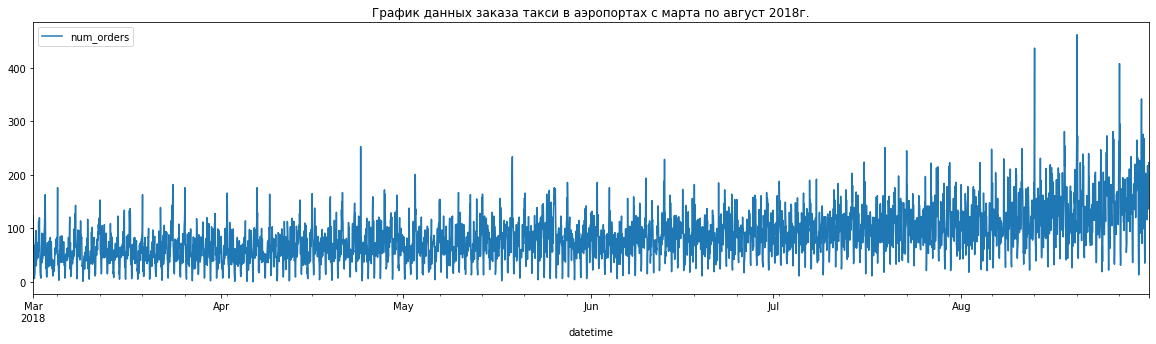

In [8]:
#Построим график данных заказа такси в аэропортах с марта по август
data.plot(title='График данных заказа такси в аэропортах с марта по август 2018г.',  figsize=(20, 5));

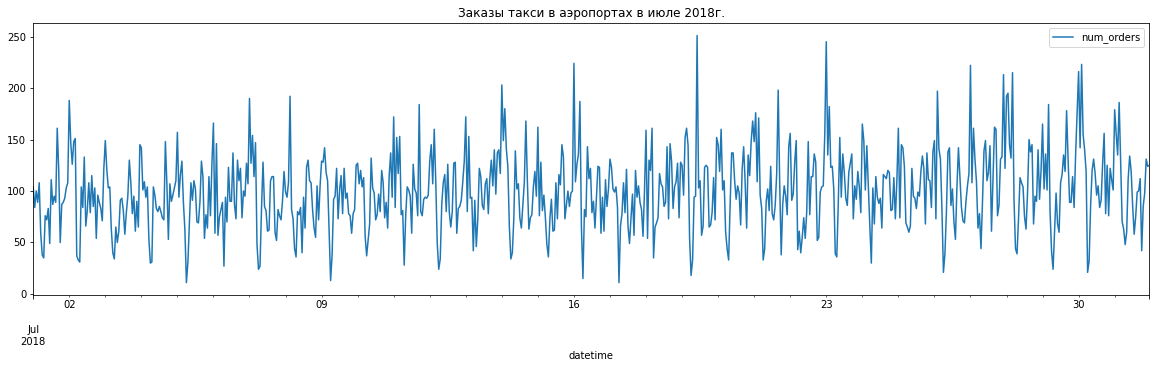

In [9]:
#Рассмотрим подробнее два последних месяца - июль и август
#Июль
data_jul = data['2018-07-01':'2018-07-31']
data_jul.plot(title='Заказы такси в аэропортах в июле 2018г.', figsize=(20, 5));

График заказов такси в июле месяце хаотичен, можно наблюдать высокий спрос заказов такси вечером и низкий - утром. Маскимум заказов в июле месяце составляло 250 заказов в час.

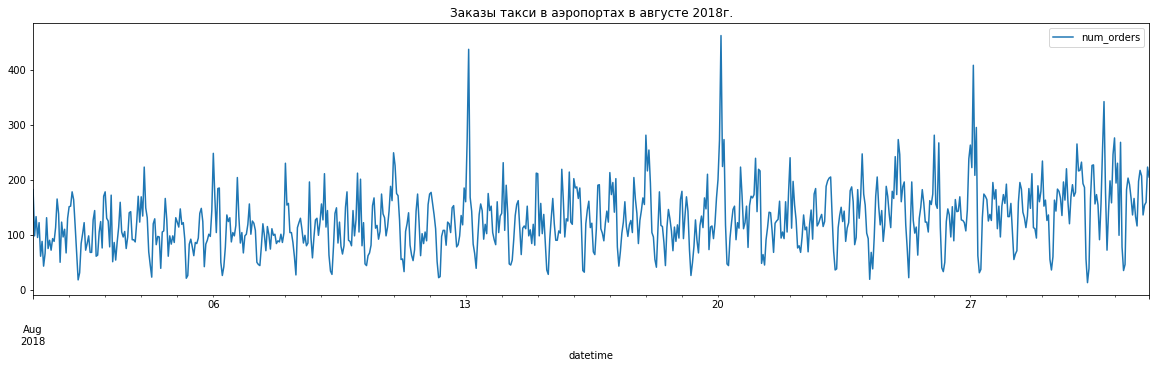

In [10]:
#Август
data_aug = data['2018-08-01':'2018-08-31']
data_aug.plot(title='Заказы такси в аэропортах в августе 2018г.', figsize=(20, 5));

График заказов такси в августе месяце так же хаотичен, однако можно наблюдать выбивающийся высокий спрос под вечер 13, 20 и 27 августа (понедельники), можно предположить, что это связано с тем, что большое количество людей возвращались из отпусков и брали билеты до конца недели (до воскресенья), чтобы подольше отдохнуть и прилететь сразу к рабочему дню. В остальные дни так же можно наблюдать высокий спрос заказов такси вечером и низкий - утром. Максимум заказов в августе месяце составляло свыше 400 заказов в час.

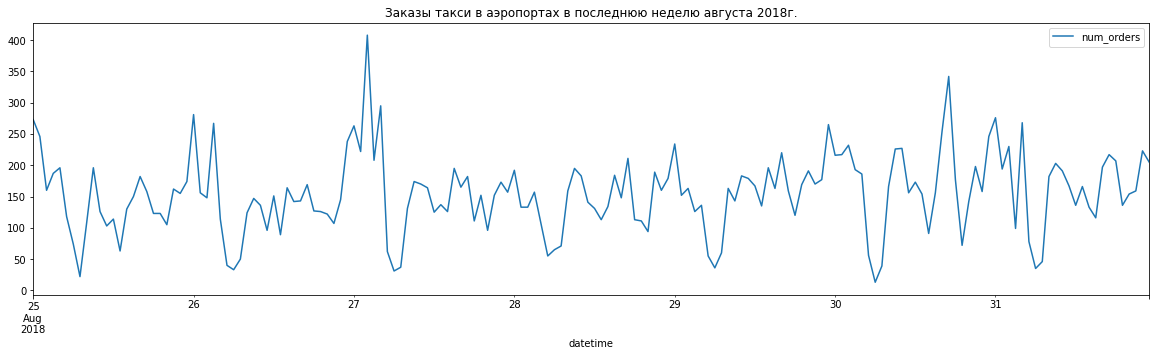

In [11]:
#Август, последняя неделя
data_aug_last_7 = data['2018-08-25':'2018-08-31']
data_aug_last_7.plot(title='Заказы такси в аэропортах в последнюю неделю августа 2018г.', figsize=(20, 5));

 Как мы можем наблюдать, заказов в первой половине дня намного меньше, чем в вечернее время, пик заказов приходится на ночное время.

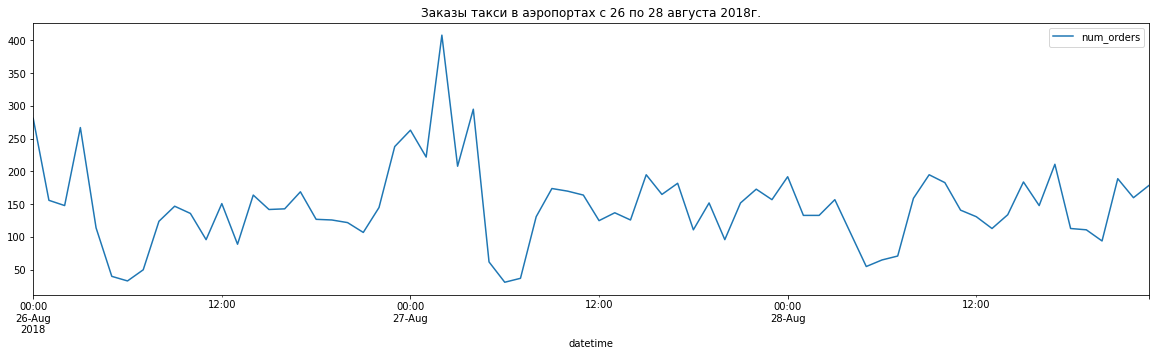

In [12]:
#Август, три дня (с 26 по 28)
data_aug_3_days_1 = data['2018-08-26':'2018-08-28']
data_aug_3_days_1.plot(title='Заказы такси в аэропортах c 26 по 28 августа 2018г.', figsize=(20, 5));

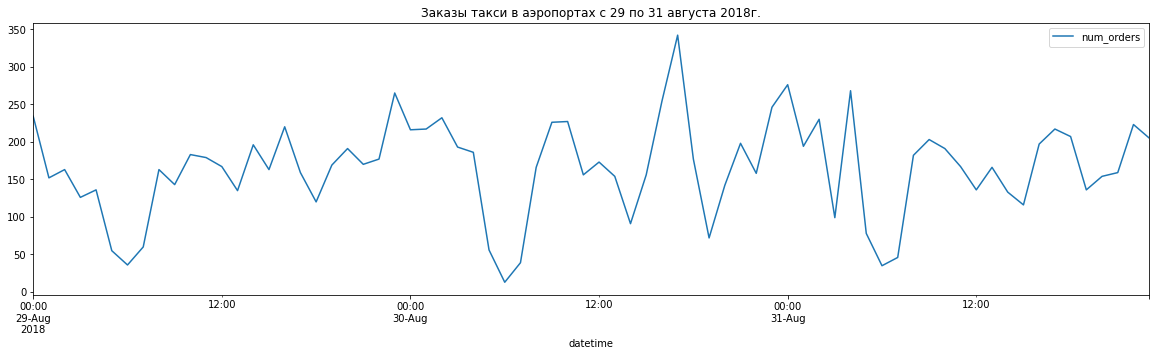

In [13]:
#Август, три дня (с 29 по 31)
data_aug_3_days_2 = data['2018-08-29':'2018-08-31']
data_aug_3_days_2.plot(title='Заказы такси в аэропортах с 29 по 31 августа 2018г.', figsize=(20, 5));

Как мы можем наблюдать, действительно, пик активности заказов наблюдается в вечернее и ночное время, рано утром - самая низкая активность.

#### Скользящее среднее

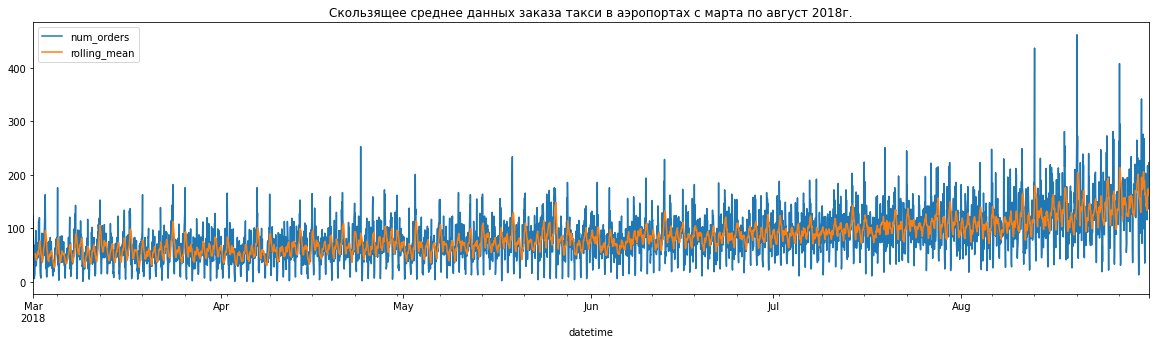

In [14]:
#Выведем скользящее среднее
data_roll = data
data_roll['rolling_mean'] = data_roll.rolling(10).mean()
data_roll.plot(title='Скользящее среднее данных заказа такси в аэропортах с марта по август 2018г.', figsize=(20, 5));

В среднем, количество заказов такси с марта по август 2018г. составляет не менее 50 заказов за час и не более 190 заказов за час.

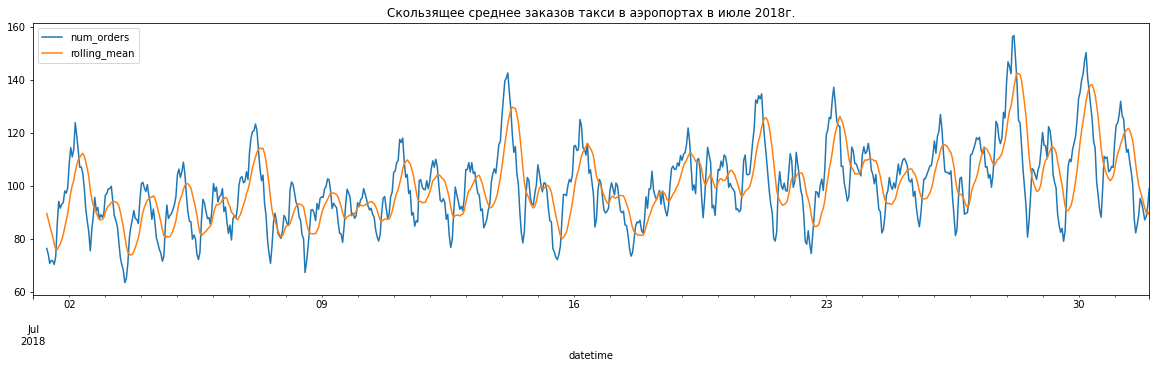

In [15]:
#Рассмотрим подробнее два последних месяца - июль и август
#Июль
data_jul = data['2018-07-01':'2018-07-31'].rolling(10).mean()
data_jul.plot(title='Скользящее среднее заказов такси в аэропортах в июле 2018г.', figsize=(20, 5));

В среднем, количество заказов такси в июле 2018г. составляет не менее 70 заказов за час и не более 140 заказов за час.

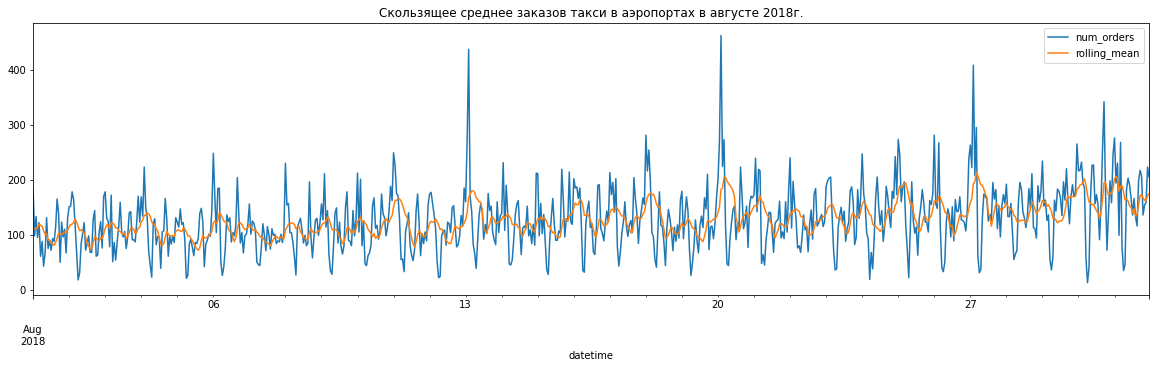

In [16]:
#Август
data_aug = data['2018-08-01':'2018-08-31']
data_aug.plot(title='Скользящее среднее заказов такси в аэропортах в августе 2018г.', figsize=(20, 5));

В среднем, количество заказов такси в августе 2018г. составляет не менее 60 заказов за час и не более 190 заказов за час.

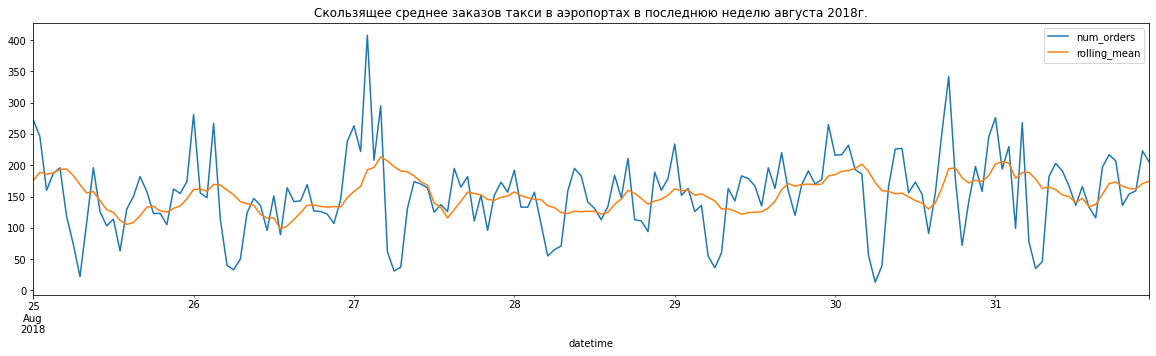

In [17]:
#Август, последняя неделя
data_aug_last_7 = data['2018-08-25':'2018-08-31']
data_aug_last_7.plot(title='Скользящее среднее заказов такси в аэропортах в последнюю неделю августа 2018г.', figsize=(20, 5));

В последнюю неделю лета, в среднем, количество заказов такси составляло не менее 100 заказов за час и не более 200 заказов за час.

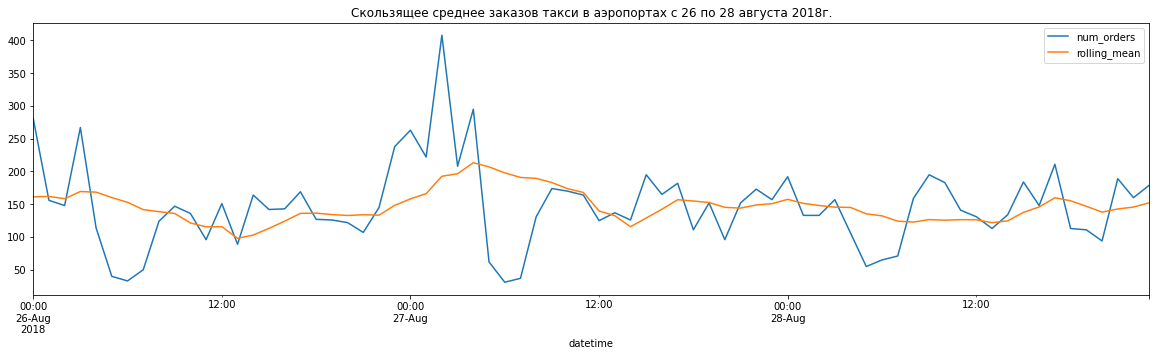

In [18]:
#Август, три дня (с 26 по 28)
data_aug_3_days_1 = data['2018-08-26':'2018-08-28']
data_aug_3_days_1.plot(title='Скользящее среднее заказов такси в аэропортах с 26 по 28 августа 2018г.', figsize=(20, 5));

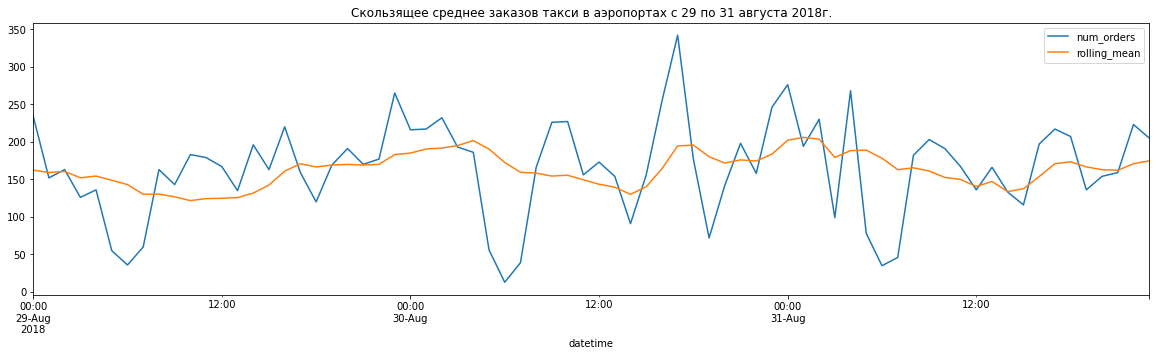

In [19]:
#Август, три дня (с 29 по 31)
data_aug_3_days_2 = data['2018-08-29':'2018-08-31']
data_aug_3_days_2.plot(title='Скользящее среднее заказов такси в аэропортах с 29 по 31 августа 2018г.', figsize=(20, 5));

Если рассматривать август месяц в разбивке по три дня, можео наблюдать, что количество заказов в среднем за час составляет не менее 120 заказов и не более 220 заказов.

#### Декомпозиция - Тренды 

In [20]:
#Декомпозируем данные и исследуем тренды
decomposed = seasonal_decompose(data_roll.num_orders)

#Обрабатываем ошибку в датафрейме с июльскими данными
data_jul['num_orders'] = data_jul['num_orders'].fillna(0)
decomposed_data_jul = seasonal_decompose(data_jul.num_orders)

decomposed_data_aug = seasonal_decompose(data_aug.num_orders)
decomposed_data_aug_last_7 = seasonal_decompose(data_aug_last_7.num_orders)
decomposed_data_aug_3_days_1 = seasonal_decompose(data_aug_3_days_1.num_orders)
decomposed_data_aug_3_days_2 = seasonal_decompose(data_aug_3_days_2.num_orders)

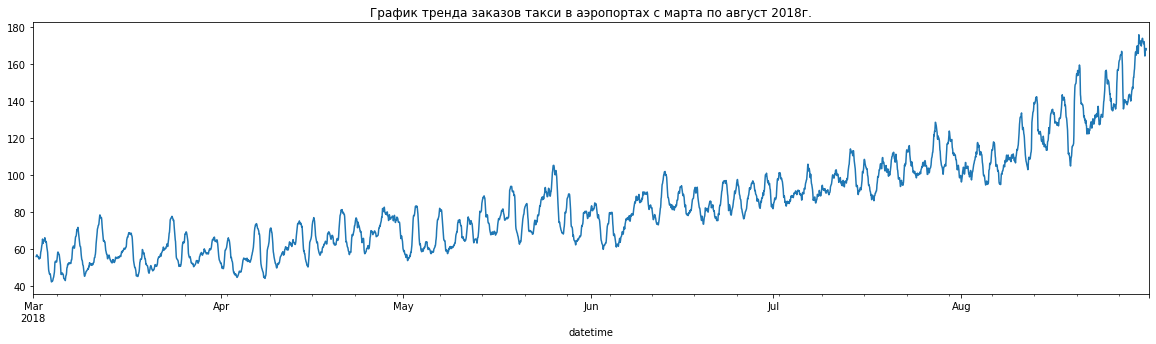

In [21]:
#График тренда заказов такси в аэропортах с марта по август 2018г.
decomposed.trend.plot(title='График тренда заказов такси в аэропортах с марта по август 2018г.', figsize=(20, 5));

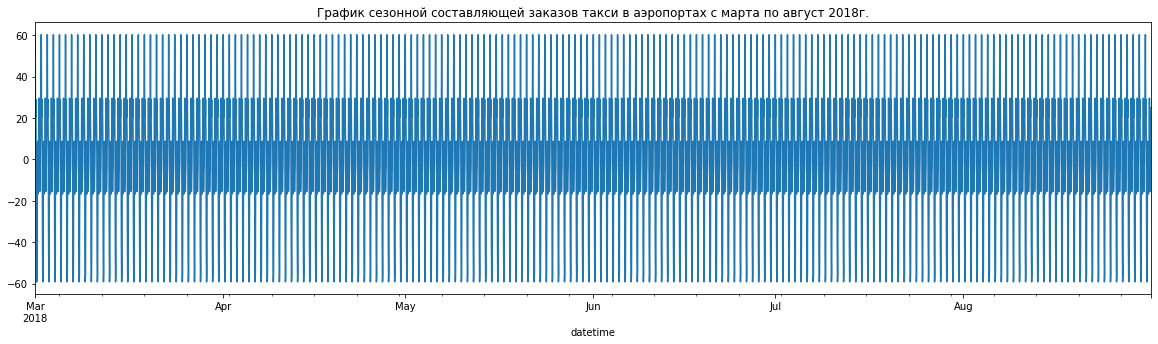

In [22]:
#График сезонной составляющей заказов такси в аэропортах с марта по август 2018г.
decomposed.seasonal.plot(title='График сезонной составляющей заказов такси в аэропортах с марта по август 2018г.', figsize=(20, 5));

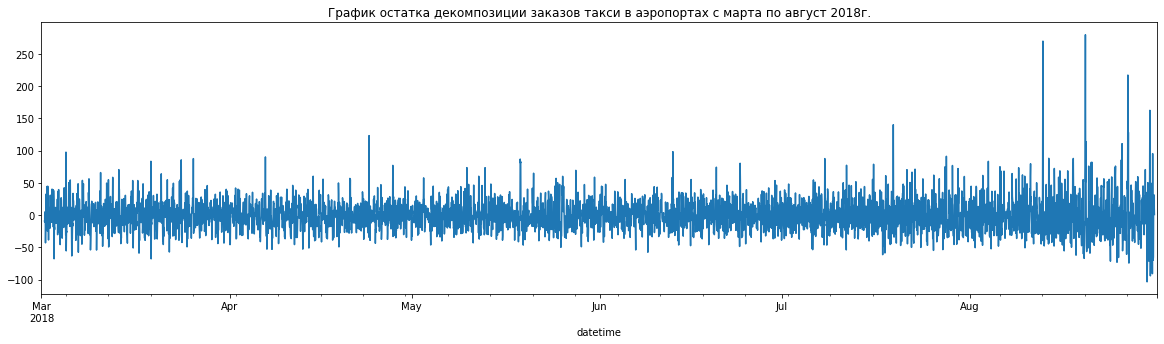

In [23]:
#График остатка декомпозиции заказов такси в аэропортах с марта по август 2018г.
decomposed.resid.plot(title='График остатка декомпозиции заказов такси в аэропортах с марта по август 2018г.', figsize=(20, 5));

Спрос на такси летом вырос по сравнению с весной, спрос на заказы такси растет с каждым последующим летним месяцем - август является лидером по заказам. <br>
Сезонность необходимо рассмотреть на более коротком промежутке, остатки необъяснимы, так как это компонента, которая не объясняется трендом и сезонностью, это шум.

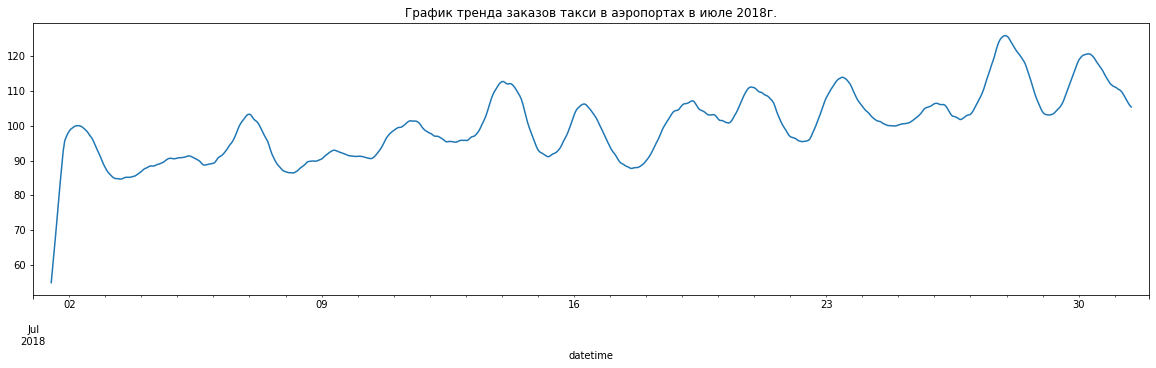

In [24]:
#График тренда заказов такси в аэропортах в июле 2018г.
decomposed_data_jul.trend.plot(title='График тренда заказов такси в аэропортах в июле 2018г.', figsize=(20, 5));

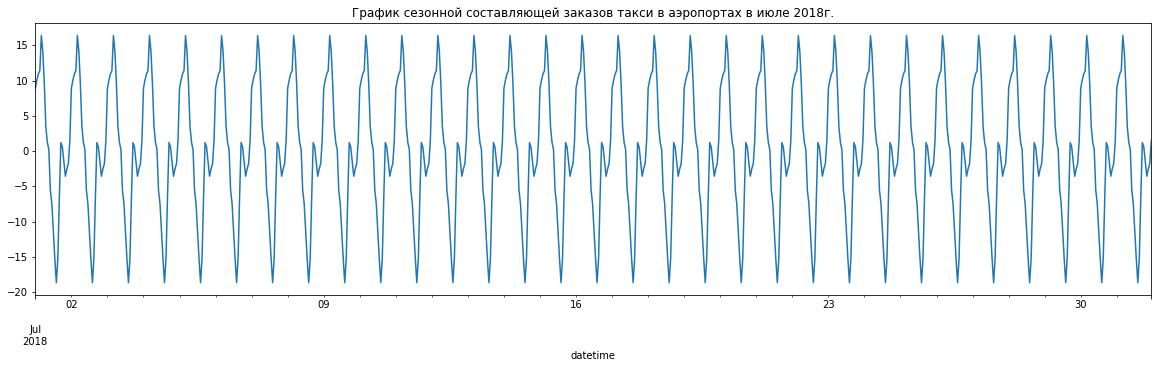

In [25]:
#График сезонной составляющей заказов такси в аэропортах в июле 2018г.
decomposed_data_jul.seasonal.plot(title='График сезонной составляющей заказов такси в аэропортах в июле 2018г.', figsize=(20, 5));

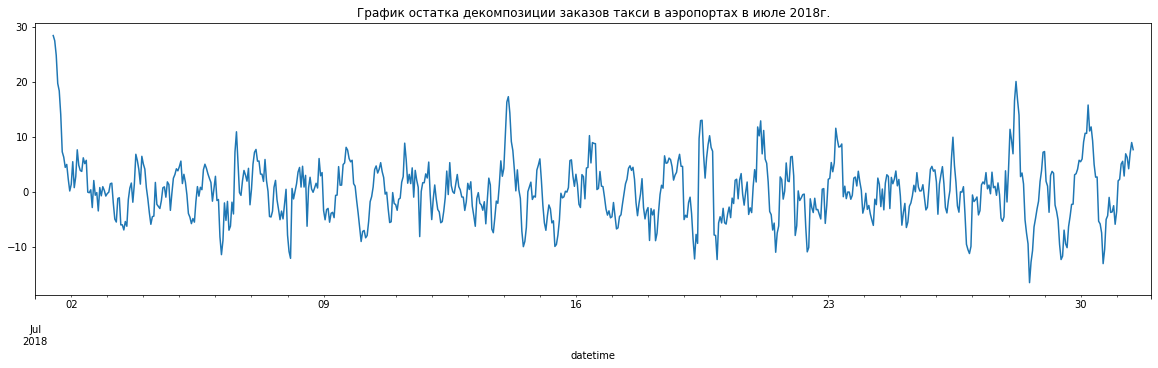

In [26]:
#График остатка декомпозиции заказов такси в аэропортах в июле 2018г.
decomposed_data_jul.resid.plot(title='График остатка декомпозиции заказов такси в аэропортах в июле 2018г.', figsize=(20, 5));

Спрос в июле на такси практически одинаков, однако под конец месяца спрос на заказы увеличился. <br>
Сезонность необходимо рассмотреть на более коротком промежутке, остатки необъяснимы.

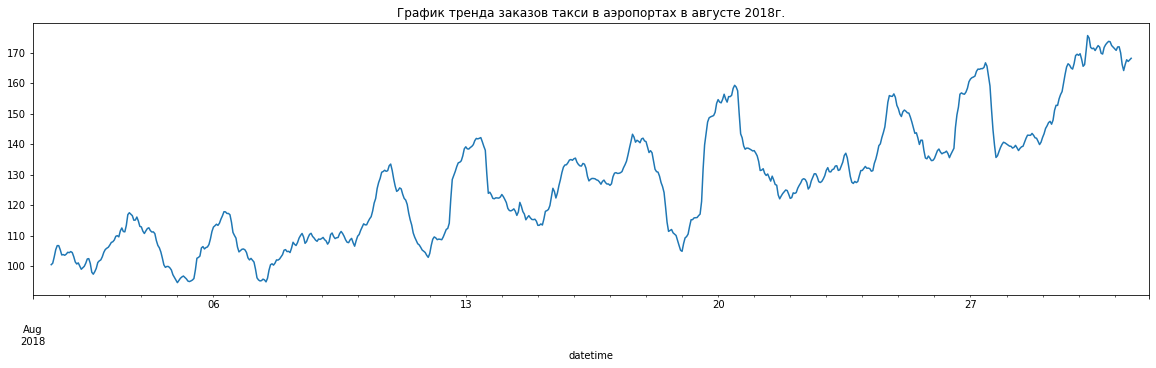

In [27]:
#График тренда заказов такси в аэропортах в августе 2018г.
decomposed_data_aug.trend.plot(title='График тренда заказов такси в аэропортах в августе 2018г.', figsize=(20, 5));

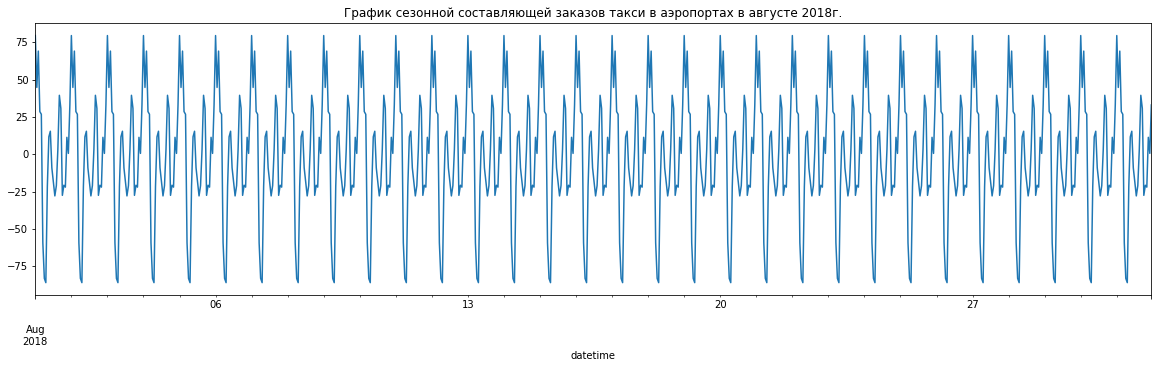

In [28]:
#График сезонной составляющей заказов такси в аэропортах в августе 2018г.
decomposed_data_aug.seasonal.plot(title='График сезонной составляющей заказов такси в аэропортах в августе 2018г.', figsize=(20, 5));

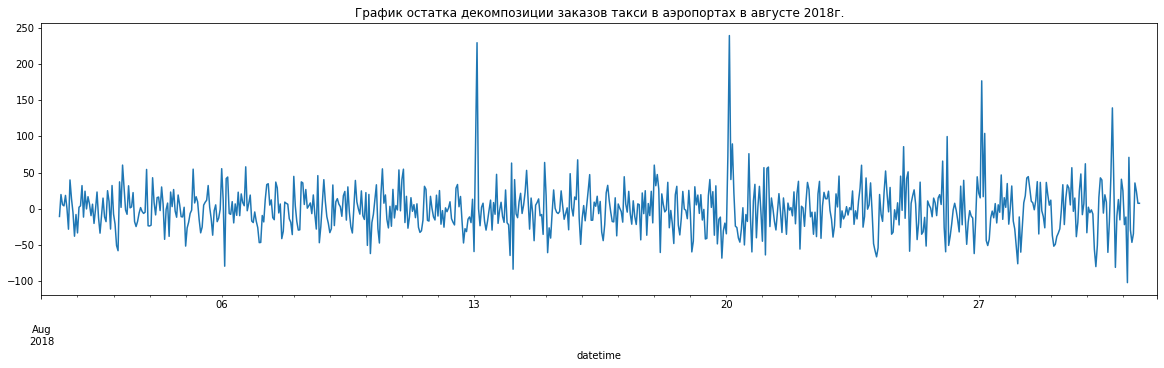

In [29]:
#График остатка декомпозиции заказов такси в аэропортах в августе 2018г.
decomposed_data_aug.resid.plot(title='График остатка декомпозиции заказов такси в аэропортах в августе 2018г.', figsize=(20, 5));

Мы можем наблюдать, что спрос на заказы такси в августе увеличивается с каждой неделей, это связано с тем, что большинство людей возвращается из отпусков под конец лета. <br>
Сезонность необходимо рассмотреть на более коротком промежутке, остатки необъяснимы, так как это компонента, которая не объясняется трендом и сезонностью, это шум.

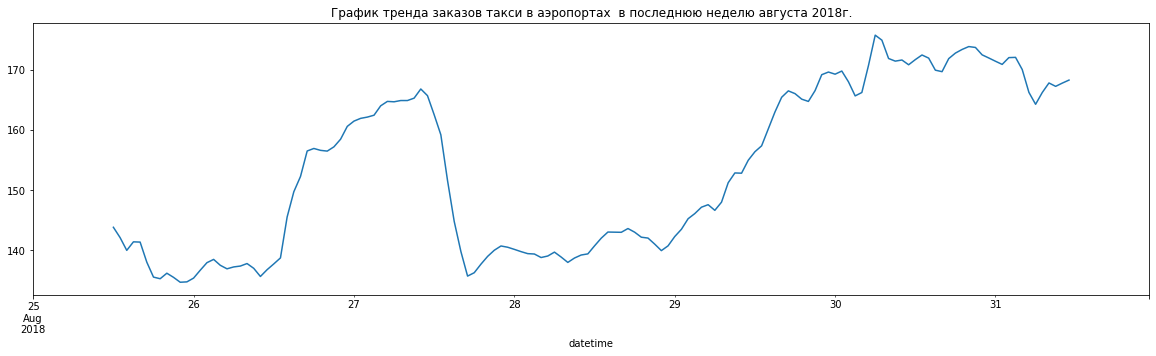

In [30]:
#График тренда заказов такси в аэропортах в последнюю неделю августа 2018г.
decomposed_data_aug_last_7.trend.plot(title='График тренда заказов такси в аэропортах  в последнюю неделю августа 2018г.', figsize=(20, 5));

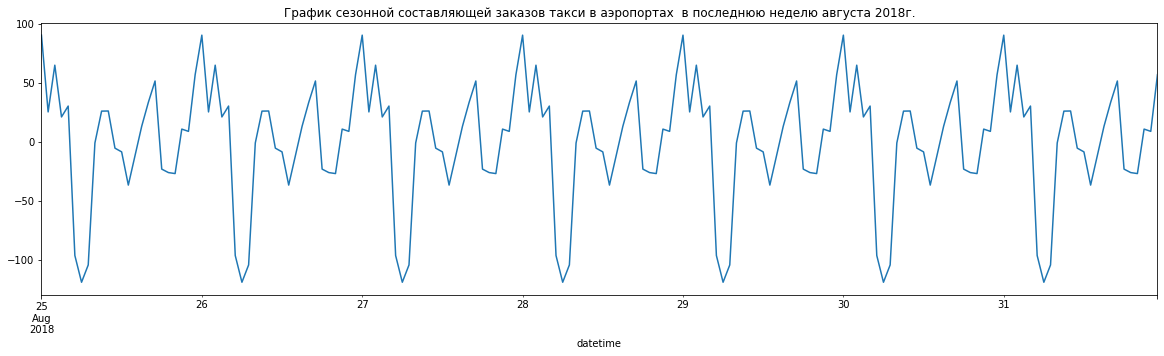

In [31]:
#График сезонной составляющей заказов такси в аэропортах в последнюю неделю августа 2018г.
decomposed_data_aug_last_7.seasonal.plot(title='График сезонной составляющей заказов такси в аэропортах  в последнюю неделю августа 2018г.', figsize=(20, 5));

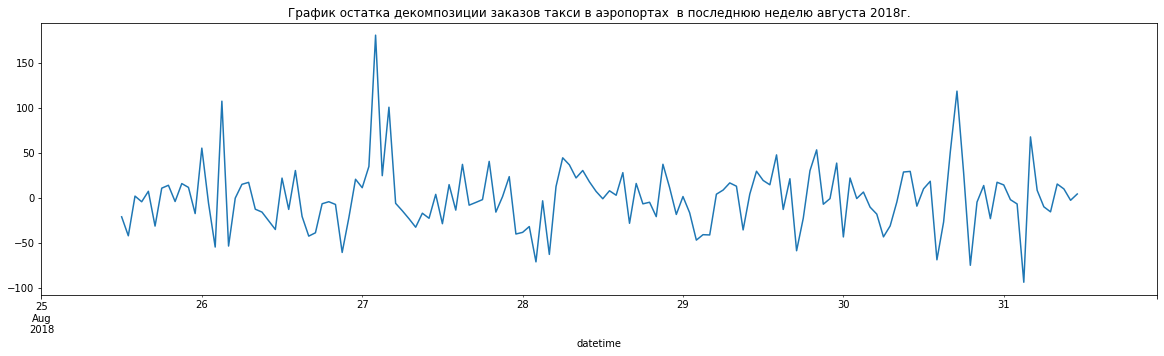

In [32]:
#График остатка декомпозиции заказов такси в аэропортах в последнюю неделю августа 2018г.
decomposed_data_aug_last_7.resid.plot(title='График остатка декомпозиции заказов такси в аэропортах  в последнюю неделю августа 2018г.', figsize=(20, 5));

Как мы можем наблюдать, большинство заказов приходится на поздний вечер воскресенья и понедельник, а так же на четверг и пятницу.
<br>
Как мы можем заметить на графике сезонной составляющей заказов такси в аэропортах  в последнюю неделю августа, что наблюдается тенденция, что меньше всего заказов потсупает ранним утром и утром. Пик заказов приходится но ночное время. 
Остатки необъяснимы.

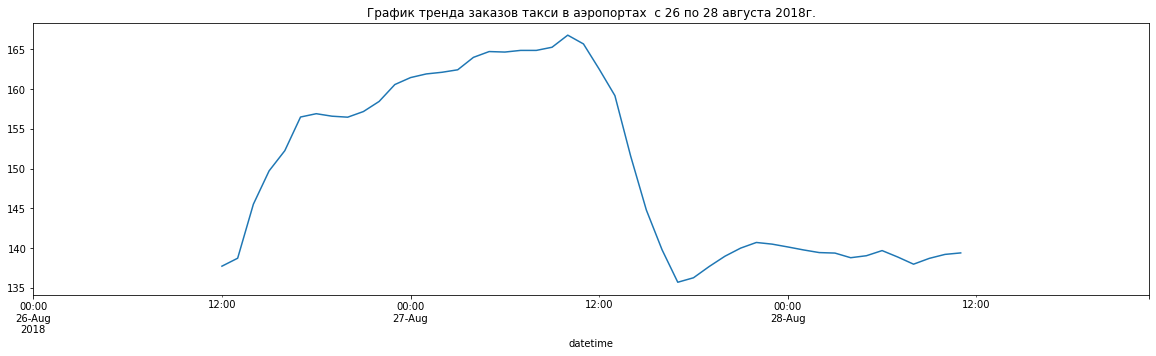

In [33]:
#График тренда заказов такси в аэропортах с 26 по 28 августа 2018г.
decomposed_data_aug_3_days_1.trend.plot(title='График тренда заказов такси в аэропортах  с 26 по 28 августа 2018г.', figsize=(20, 5));

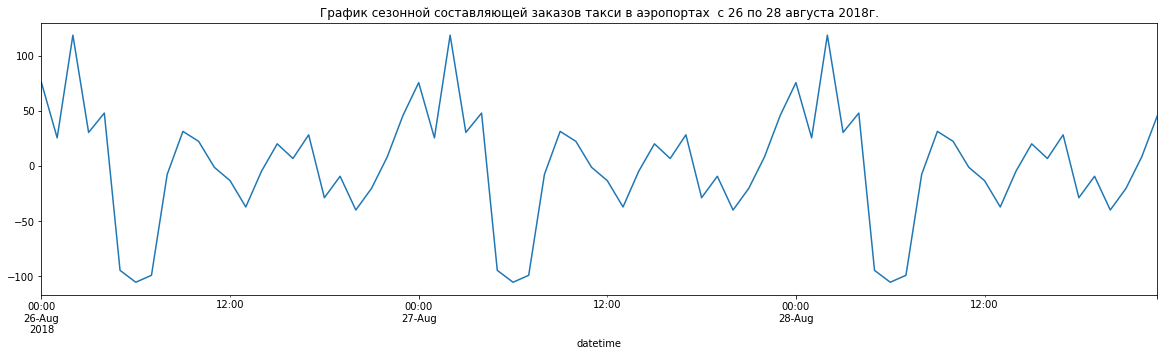

In [34]:
#График сезонной составляющей заказов такси в аэропортах с 26 по 28 августа 2018г.
decomposed_data_aug_3_days_1.seasonal.plot(title='График сезонной составляющей заказов такси в аэропортах  с 26 по 28 августа 2018г.', figsize=(20, 5));

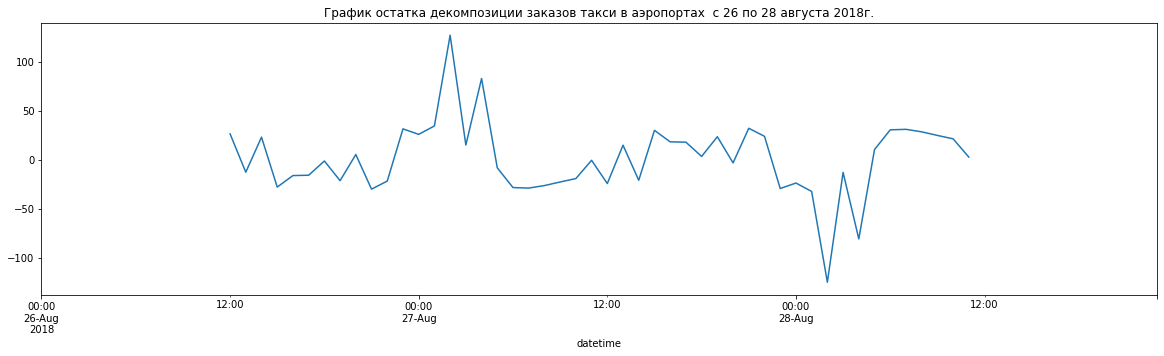

In [35]:
#График остатка декомпозиции заказов такси в аэропортах с 26 по 28 августа 2018г.
decomposed_data_aug_3_days_1.resid.plot(title='График остатка декомпозиции заказов такси в аэропортах  с 26 по 28 августа 2018г.', figsize=(20, 5));

Высокий спрос приходится в ночь с воскресенья на понедельник, а так же на раннее утро понедельника. <br>
Как мы можем наблюдать на графике сезонной составляющей заказов такси в аэропортах  с 26 по 28 августа 2018г, самый низкий спрос на заказы такси наблюдается рано утром, примерно с 05:00 до 07:00 утра, высокий спрос приходится на ночное время, примерно с 00:00 и до 03:00 ночи. Остатки необъяснимы. 

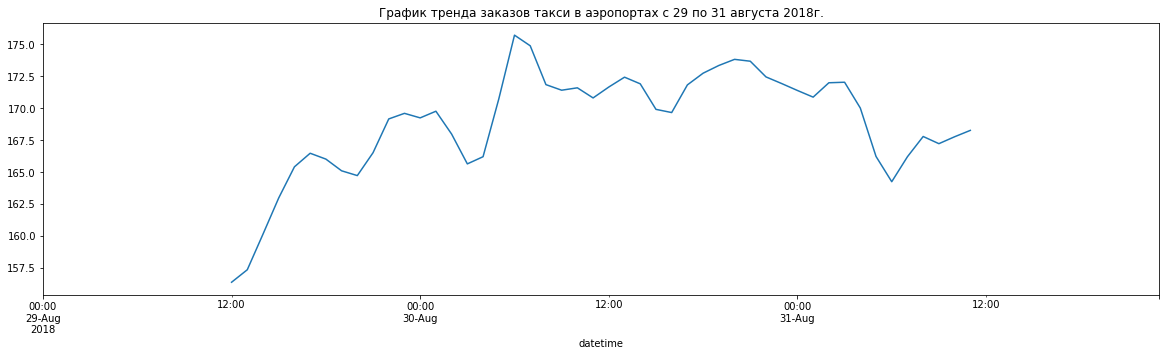

In [36]:
#График тренда заказов такси в аэропортах с 29 по 31 августа 2018г.
decomposed_data_aug_3_days_2.trend.plot(title='График тренда заказов такси в аэропортах с 29 по 31 августа 2018г.', figsize=(20, 5));

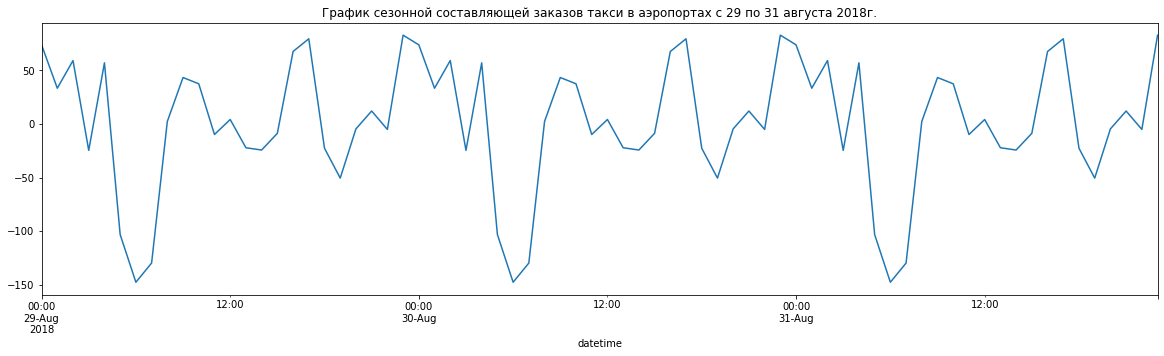

In [37]:
#График сезонной составляющей заказов такси в аэропортах с 29 по 31 августа 2018г.
decomposed_data_aug_3_days_2.seasonal.plot(title='График сезонной составляющей заказов такси в аэропортах с 29 по 31 августа 2018г.', figsize=(20, 5));

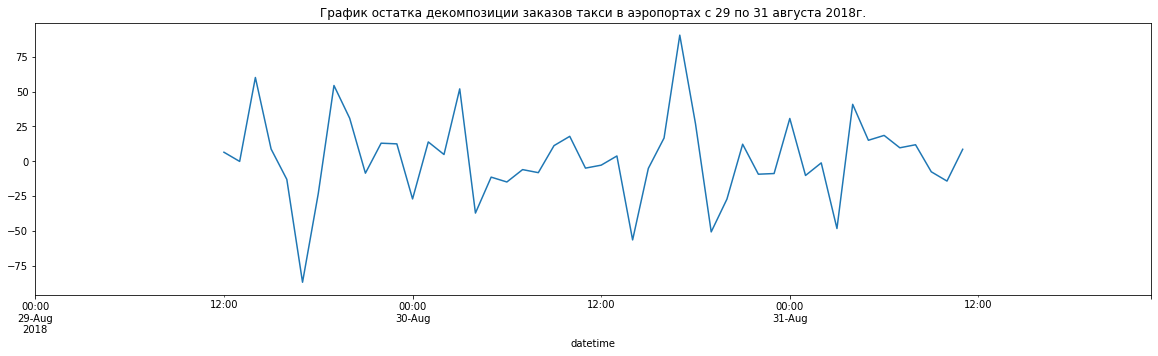

In [38]:
#График тренда остатка декомпозиции такси в аэропортах с 29 по 31 августа 2018г.
decomposed_data_aug_3_days_2.resid.plot(title='График остатка декомпозиции заказов такси в аэропортах с 29 по 31 августа 2018г.', figsize=(20, 5));

Как мы можем наблюдать, высокий спрос начинается с утра четверга и продолжается вплоть до пятницы. <br>
Как мы можем заметить на графике сезонной составляющей заказов такси в аэропортах с 29 по 31 августа, под конец лета и всех отпусков, высокий спрос на заказы такси начинается ранним утром и заканчивается поздней ночью, пик активности приходится, примерно с 07:00 утра до 03:00 ночи. Самый низкий спрос сохраняется примерно около 06:00 утра. Остатки необъяснимы.

Так же можно отменить, что у всех рассматриваемых временных рядов стохастический процесс нестационарный, так как распределения меняются.

#### Вывод:
* Мы проанализировали данные:
    * Пик активности заказов наблюдается в вечернее и ночное время, рано утром - самая низкая активность;
    * В среднем, количество заказов такси с марта по август 2018г. составляет не менее 50 заказов за час и не более 190 заказов за час;
    * Спрос на такси летом вырос по сравнению с весной, спрос на заказы такси растет с каждым последующим летним месяцем - август является лидером по заказам;
    * У всех рассматриваемых временных рядов стохастический процесс нестационарный, так как распределения меняются.

## 3. Обучение

In [39]:
#Напишем функцию для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df = df.dropna()
    
    return df

In [40]:
#Вводим новую переменную, чтобы не изменять глобальную переменную при генерации новых признаков
df = data
make_features(df, 24, 48)

,num_orders,rolling_mean,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,59.791667,2018,3,3,5,72.0,119.0,101.0,93.0,...,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0
2018-03-03 01:00:00,108,60.604167,2018,3,3,5,163.0,72.0,119.0,101.0,...,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0
2018-03-03 02:00:00,25,61.083333,2018,3,3,5,108.0,163.0,72.0,119.0,...,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0
2018-03-03 03:00:00,64,60.125000,2018,3,3,5,25.0,108.0,163.0,72.0,...,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0
2018-03-03 04:00:00,44,60.083333,2018,3,3,5,64.0,25.0,108.0,163.0,...,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,170.895833,2018,8,31,4,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0
2018-08-31 20:00:00,154,170.208333,2018,8,31,4,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0
2018-08-31 21:00:00,159,169.437500,2018,8,31,4,154.0,136.0,207.0,217.0,...,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0


In [41]:
#Разобьем датасет на обучающую, тестовую и валидационную выборки
#Сделали тестовую выборку размером 10% от исходных данных
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()
test, valid = train_test_split(test, shuffle=False, test_size=0.5)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

In [42]:
print('Размер обучающей выборки', train.shape)
print('Размер тестовой выборки', test.shape)
print('Размер валидационной выборки', valid.shape)

Размер обучающей выборки (3523, 2)
Размер тестовой выборки (442, 2)
Размер валидационной выборки (442, 2)


**Модель Линейной регрессии - LinearRegression**

In [52]:
%%time

model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
rmse = mean_squared_error(target_valid, predictions) ** 0.5

print('RMSE наилучшей модели линейной регрессии на валидационной выборке:', rmse)

RMSE наилучшей модели линейной регрессии на валидационной выборке: 55.910844365717836
Wall time: 16 ms


**Модель Случайного леса - RandomForestClassifier**

In [68]:
%%time
#Подбираем гипермараметры

for est in range(1, 11, 2):
    for depth in range(1, 11):
        model_rf = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_rf.fit(features_train, target_train)
        predicted_rf = model_rf.predict(features_valid)
        result =  mean_squared_error(target_valid, predicted_rf)**0.5
        if result < best_result_rf:
            best_model_rf = model_rf
            best_result_rf = result
            best_est_rf = est
            best_depth_rf = depth
            
print('RMSE наилучшей модели случайного леса на валидационной выборке:', best_result_rf)
print('Количество деревьев:', best_est_rf)
print('Максимальная глубина:', depth)

RMSE наилучшей модели случайного леса на валидационной выборке: 58.12588220740111
Количество деревьев: 1
Максимальная глубина: 10
Wall time: 993 ms


In [69]:
%time

model_rf = RandomForestRegressor(random_state=12345, n_estimators=1, max_depth=10)
model_rf.fit(features_train, target_train)
predicted_rf = model_rf.predict(features_valid)
rmse_rf = mean_squared_error(target_valid, predicted_rf) ** 0.5

print('RMSE наилучшей модели случайного леса на валидационной выборке::', rmse_rf)

Wall time: 0 ns
RMSE наилучшей модели случайного леса на валидационной выборке:: 69.7564509593516


**Модель бустинга - LightGBMRegressor**

In [45]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
model_lgbmr = LGBMRegressor() 
parameters = {'num_leaves':[25, 50, 100], 'max_depth':[1, 5, 15], 'random_state':[12345]}

clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error', cv=my_cv)
clf.fit(features_train, target_train)

print('RMSE наилучшей модели:', clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rsme_lgbmr = (max(mts) * -1) ** 0.5
rsme_lgbmr

RMSE наилучшей модели: {'max_depth': 1, 'num_leaves': 25, 'random_state': 12345}



32.66825427562147

In [46]:
%%time

model_lgbmr = LGBMRegressor(num_leaves=25, max_depth=1, random_state=12345)
model_lgbmr.fit(features_train, target_train)
predict_lgbmr = model_lgbmr.predict(features_valid)
rmse_model_lgbmr = mean_squared_error(target_valid, predict_lgbmr) ** 0.5

print('RMSE наилучшей модели бустинга - LightGBMRegressor на валидационной выборке:', rmse_model_lgbmr)

RMSE наилучшей модели бустинга - LightGBMRegressor на валидационной выборке: 63.571119039043126
CPU times: user 4.78 s, sys: 61.9 ms, total: 4.84 s
Wall time: 4.85 s


**Модель бустинга - CatBoostRegressor**

In [73]:
%%time

model_cat = CatBoostRegressor(depth=15, learning_rate=0.3, iterations=10)
model_cat.fit(features_train, target_train, verbose=10)
predict_cat = model_cat.predict(features_valid)
rmse_model_cat = mean_squared_error(target_valid, predict_cat) ** 0.5

print('RMSE наилучшей модели бустинга - CatBoostRegressor на валидационной выборке::', rmse_model_cat)

0:	learn: 33.5191133	total: 451ms	remaining: 4.06s
9:	learn: 31.0682670	total: 7.89s	remaining: 0us
RMSE наилучшей модели бустинга - CatBoostRegressor на валидационной выборке:: 64.39188718977155
Wall time: 7.96 s


#### Вывод:
* Мы обучили разные модели с различными гиперпараметрами:
    * Наилучшей моделью оказалась модель линейной регрессии - LinearRegression, с результатом RMSE на валидационной выборке 55.910844365717836.
* Сделали тестовую выборку размером 10% от исходных данных.

## 4. Тестирование

In [83]:
%%time
#Проверяем на тестовой выборке наилучшую модель - LinearRegression

model_ln = LinearRegression()
model_ln.fit(features_train, target_train)
predictions_ln = model.predict(features_test)
rmse_ln = mean_squared_error(target_test, predictions_ln) ** 0.5


print('RMSE наилучшей модели линейной регрессии - LinearRegression на тестовой выборке:', rmse_ln)

RMSE наилучшей модели линейной регрессии - LinearRegression на тестовой выборке: 44.45736586680238
Wall time: 3.22 ms


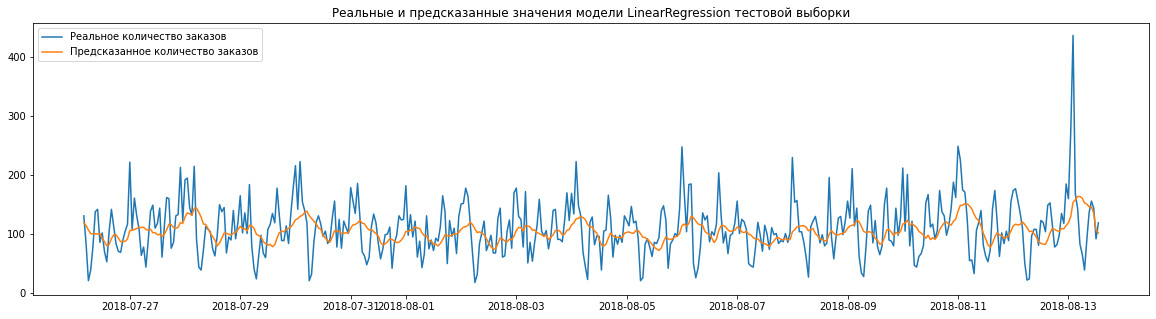

In [85]:
#Визуализируем реальные и предсказанные значения тестовой выборки
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(target_test.index, target_test, label='Реальное количество заказов')
ax.plot(target_test.index, predictions_ln, label='Предсказанное количество заказов')
plt.title('Реальные и предсказанные значения модели LinearRegression тестовой выборки')
plt.legend()
plt.show()

Как мы можем наблюдать на графике, модель линейной регрессии отлично справляется с задачей и качество предсказаний находится на высоком уровне.

#### Вывод:
* Мы проверьте данные на тестовой выборке :
    * RMSE наилучшей модели линейной регрессии - LinearRegression на тестовой выборке составляет: 44.45736586680238.
* Добились результата "значение метрики RMSE на тестовой выборке должно быть не больше 48"

## Общий вывод:
1. Мы загрузили и ознакомились с представленным датафреймом.
2. Выполнили ресемплирование данных по одному часу, всего в датафрейме, после ресемплирования остался 1 столбец и 4 416 записи со временным промежутком с 1 марта 2018 года по 31 августа 2018 года.
3. Мы проанализировали данные:
    * Пик активности заказов наблюдается в вечернее и ночное время, рано утром - самая низкая активность;
    * В среднем, количество заказов такси с марта по август 2018г. составляет не менее 50 заказов за час и не более 190 заказов за час;
    * Спрос на такси летом вырос по сравнению с весной, спрос на заказы такси растет с каждым последующим летним месяцем - август является лидером по заказам;
    * У всех рассматриваемых временных рядов стохастический процесс нестационарный, так как распределения меняются.
4. Мы обучили разные модели с различными гиперпараметрами:
    * Наилучшей моделью оказалась модель линейной регрессии - LinearRegression, с результатом RMSE на валидационной выборке 55.910844365717836.
5. Сделали тестовую выборку размером 10% от исходных данных.
6. Мы проверьте данные на тестовой выборке :
    * RMSE наилучшей модели линейной регрессии - LinearRegression на тестовой выборке составляет: 44.45736586680238.
7. Добились результата "значение метрики RMSE на тестовой выборке должно быть не больше 48".

<br>
Рекомендации:<br>
Мы построили модель, которая быстро и с наибольшим качеством прогрозирует количество заказов такси на следующий час. В связи с этим, компания «Чётенькое такси» может рационрально распределить свои силы и в нужное время привлечь больше водителей в период пиковой нагрузки, тем самым получив надежных работников и верных клиентов, более того, данная модель поможет в клиентоориентированности - с увеличением водителей в места пиковой нагрузки, завоюет внимание потребителей, тем самым  привлечет еще больше постоянных клиентов.